<a href="https://colab.research.google.com/github/550tealeaves/DATA-70500-working-with-data/blob/main/HW5_SurveyDataAnalysisPew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Some Analysis of Pew Research Survey Data

This is a public opinion data source that lends itself to all sorts of timely questions about religion and politics. This is the kind of thing that you could do on the research project if you were interested in attitudes about science and technology (and could find an appropriate dataset).


In [23]:
# Code block 1ab: Installing some libraries we'll need
!pip install pyreadstat
!pip install researchpy

In [24]:
# Code block 1b: Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sb
import math
import matplotlib.pyplot as plt
import researchpy as rp
from pandas.api.types import CategoricalDtype

You can download the data from the Pew Center, https://www.pewresearch.org/science/datasets/ and then copy the files to your Drive and read the data into your notebook.

I'm using the American Trends Panel Wave 55 here. The data download includes a codebook for the survey, in this case, a file named ATP W55 topline.pdf. For your convenience, I've linked to it here: https://www.dropbox.com/s/o799oggh6ii17r5/ATP%20W55%20topline.pdf?dl=0

Here's a general codebook for the ATP data that is useful for identifying demographic variables to use in the analysis. (These are variables that are included in all of the waves of ATP.) https://www.dropbox.com/s/qe4fsmbq1fvr76i/Codebook-and-instructions-for-working-with-ATP-data.pdf?dl=0

We'll use the codebook to find some variables of interest and then do some basic analysis and visualization.

In [25]:
# Code block 2: Reading in data
# The format of this data source is an SPSS data file, .sav, so we installed a library--pyreadstat--that extends pandas
# by adding another read method, read_spss. We use this to read the SPSS file into a new data object.
# I mounted my Drive in this notebook and read the file by copying the local path.

ATPW115_df = pd.read_spss('ATP W115.sav')

In [26]:
ATPW115_df.head()

,QKEY,INTERVIEW_START_W115,INTERVIEW_END_W115,DEVICE_TYPE_W115,LANG_W115,XPANEL_W115,PARJOB_W115,RAISED_W115,RAISEDSIMOE_C1_W115,RAISEDSIMOE_C2_W115,...,F_INTFREQ,F_VOLSUM,F_INC_TIER2,F_KIDS1,F_KIDS2,WEIGHT_W115,WEIGHT_ELEM_W115,WEIGHT_MIDDLE_W115,WEIGHT_HIGH_W115,WEIGHT_K12_W115
0,162.0,2022-09-20 18:52:46,2022-09-20 19:10:49,Smartphone,Spanish,KP,Good,A somewhat different way,NaN,NaN,...,Several times a week,No,Lower income,Yes,No,3.464696,3.464696,0.000000,0.000000,3.464696
1,163.0,2022-09-20 18:53:22,2022-09-20 19:51:05,Laptop/PC,English,KP,Very good,A somewhat similar way,Religion,NaN,...,Several times a day,Yes,Upper income,Yes,Yes,0.500483,0.000000,0.000000,0.500483,0.500483
2,164.0,2022-09-20 18:53:59,2022-09-20 19:13:57,Tablet,English,KP,Excellent,Neither similar nor different,NaN,NaN,...,Almost constantly,No,Lower income,Yes,No,2.427745,4.855489,0.000000,0.000000,2.427745
3,168.0,2022-09-20 18:55:56,2022-09-20 19:15:55,Smartphone,English,KP,Very good,A very different way,NaN,NaN,...,Almost constantly,Yes,Middle income,Yes,No,1.548307,1.548307,0.000000,0.000000,1.548307
4,169.0,2022-09-20 18:55:57,2022-09-24 12:05:23,Smartphone,English,KP,Excellent,A very different way,NaN,NaN,...,Almost constantly,No,Upper income,Yes,Yes,1.637104,0.000000,3.274207,0.000000,1.637104


In [27]:
# Code block 3: Inspecting variables
# I've found a relationship between variables that I want to examine: What effect did the first year of COVID-19 have on homeschooled children?

# what do you do with missing data? - treat it as missing b/c we don't know what the respondent would have answered

ATPW115_df['CVDEDUC1_W115']

,CVDEDUC1_W115
0,Somewhat positive
1,Somewhat negative
2,Neither positive nor negative
3,Child was not of school age at the time
4,Very positive
...,...
3752,Neither positive nor negative
3753,Neither positive nor negative
3754,Child was not of school age at the time
3755,Very positive


In [28]:
#If string has "refused", convert it to not a number

#Ordinal variables - goes from most to least skeptical
ATPW115_df['CVDEDUC1_W115r'] = np.where(ATPW115_df['CVDEDUC1_W115'].str.contains('Refused'), np.nan, ATPW115_df['CVDEDUC1_W115'])
ATPW115_df['CVDEDUC1_W115r']

,CVDEDUC1_W115r
0,Somewhat positive
1,Somewhat negative
2,Neither positive nor negative
3,Child was not of school age at the time
4,Very positive
...,...
3752,Neither positive nor negative
3753,Neither positive nor negative
3754,Child was not of school age at the time
3755,Very positive


In [29]:
# Here, we're using a tool to specify the order of a categorical variable. This is important
# when the variable is ordinal rather than nominal -- that is, the order of the categories
# matters
# will po
cat_type = CategoricalDtype(categories=["Very positive", "Somewhat positive", "Neither positive nor negative", "Somewhat negative", "Very negative", "Not sure", "Non-school age child"], ordered=True)
ATPW115_df['CVDEDUC1_W115r2'] = ATPW115_df['CVDEDUC1_W115r'].astype(cat_type)


In [30]:
ATPW115_df['SCHOOLTYPE_W115r'] = np.where(ATPW115_df['SCHOOLTYPE_W115'].str.contains('Refused'), np.nan, ATPW115_df['SCHOOLTYPE_W115'])
ATPW115_df['SCHOOLTYPE_W115r']

,SCHOOLTYPE_W115r
0,In a public school
1,In a public school
2,In a public school
3,In a charter school
4,In a private school
...,...
3752,In a public school
3753,In a public school
3754,In a public school
3755,In a public school


In [9]:
ATPW115_df['SCHOOLTYPE_W115r']

,SCHOOLTYPE_W115r
0,In a public school
1,In a public school
2,In a public school
3,In a charter school
4,In a private school
...,...
3752,In a public school
3753,In a public school
3754,In a public school
3755,In a public school


In [10]:
# Code block 4a: Analysis with a crosstabulation (bivariate percentage table)

#chi-square b
crosstab, sigtab = rp.crosstab(ATPW115_df.CVDEDUC1_W115r2, ATPW115_df.SCHOOLTYPE_W115r, prop='col', test='chi-square')
crosstab


/usr/local/lib/python3.10/dist-packages/researchpy/crosstab.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Pearson Chi-square ( 18.0) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = f"Pearson Chi-square ({dof: .1f}) = "


SCHOOLTYPE_W115r                      \
SCHOOLTYPE_W115r                            Homeschooled In a charter school   
CVDEDUC1_W115r2                                                                
Very positive                                       2.55                2.72   
Somewhat positive                                   6.12                5.43   
Neither positive nor negative                      45.92               26.09   
Somewhat negative                                  14.80               37.50   
Very negative                                       9.69               19.02   
Not sure                                            2.04                2.72   
Child was not of school age at the time            18.88                6.52   
All                                               100.00              100.00   

                                                             \
SCHOOLTYPE_W115r                        In a private school   
CVDEDUC1_W115r2                                               
Very positive                                          2.39   
Somewhat positive                                      3.41   
Neither positive nor negative                         29.35   
Somewhat negative                                     37.20   
Very negative                                         18.43   
Not sure                                               1.02   
Child was not of school age at the time                8.19   
All                                                  100.00   

                                                                    
SCHOOLTYPE_W115r                        In a public school     All  
CVDEDUC1_W115r2                                                     
Very positive                                         1.49    1.70  
Somewhat positive                                     4.11    4.25  
Neither positive nor negative                        22.41   24.67  
Somewhat negative                                    40.03   38.10  
Very negative                                        20.92   19.90  
Not sure                                              3.64    3.25  
Child was not of school age at the time               7.40    8.12  
All                                                 100.00  100.00

In [11]:
print(sigtab)

                 Chi-square test   results
0  Pearson Chi-square ( 18.0) =   129.5127
1                     p-value =     0.0000
2                  Cramer's V =     0.1157


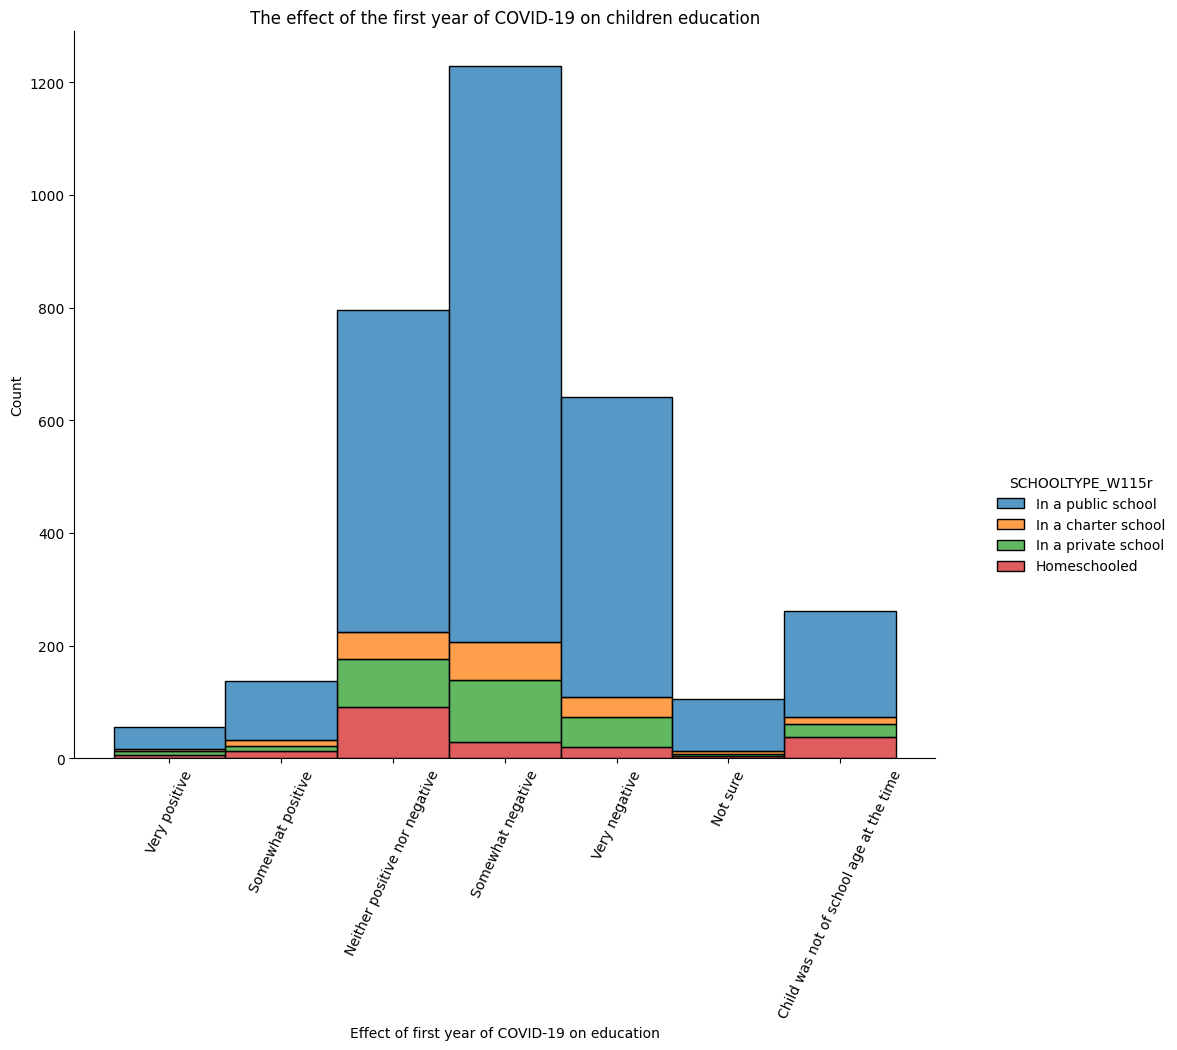

In [12]:
p = sb.displot(ATPW115_df, x='CVDEDUC1_W115r2', hue='SCHOOLTYPE_W115r', multiple="stack", height=8, aspect=1.25)
plt.title('The effect of the first year of COVID-19 on children education')
plt.xlabel('Effect of first year of COVID-19 on education')
plt.xticks(rotation=65)
plt.show()

In [13]:
ATPW115_df['CHGENDER_W115r'] = np.where(ATPW115_df['CHGENDER_W115'].str.contains('Refused'), np.nan, ATPW115_df['CHGENDER_W115'])
ATPW115_df['CHGENDER_W115r']

,CHGENDER_W115r
0,A girl
1,A boy
2,A boy
3,A girl
4,A boy
...,...
3752,A boy
3753,A girl
3754,A boy
3755,A girl


In [14]:
# Code block 4b: More analysis with a crosstabulation (bivariate percentage table)
crosstab, sigtab = rp.crosstab(ATPW115_df.CVDEDUC1_W115r2, ATPW115_df.CHGENDER_W115r, prop='col', test='chi-square')
crosstab


/usr/local/lib/python3.10/dist-packages/researchpy/crosstab.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Pearson Chi-square ( 18.0) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = f"Pearson Chi-square ({dof: .1f}) = "


CHGENDER_W115r                    \
CHGENDER_W115r                                   A boy  A girl Nonbinary   
CVDEDUC1_W115r2                                                            
Very positive                                     1.48    1.88       0.0   
Somewhat positive                                 4.26    3.97      20.0   
Neither positive nor negative                    25.09   24.43      20.0   
Somewhat negative                                38.28   38.22      15.0   
Very negative                                    20.30   19.18      40.0   
Not sure                                          2.78    3.70       5.0   
Child was not of school age at the time           7.81    8.61       0.0   
All                                             100.00  100.00     100.0   

                                                         
CHGENDER_W115r                            Other     All  
CVDEDUC1_W115r2                                          
Very positive                              8.33    1.71  
Somewhat positive                          8.33    4.25  
Neither positive nor negative             12.50   24.66  
Somewhat negative                         29.17   38.04  
Very negative                             25.00   19.94  
Not sure                                   8.33    3.26  
Child was not of school age at the time    8.33    8.14  
All                                      100.00  100.00

In [15]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 18.0) =,36.5770
1,p-value =,0.0059
2,Cramer's V =,0.0615


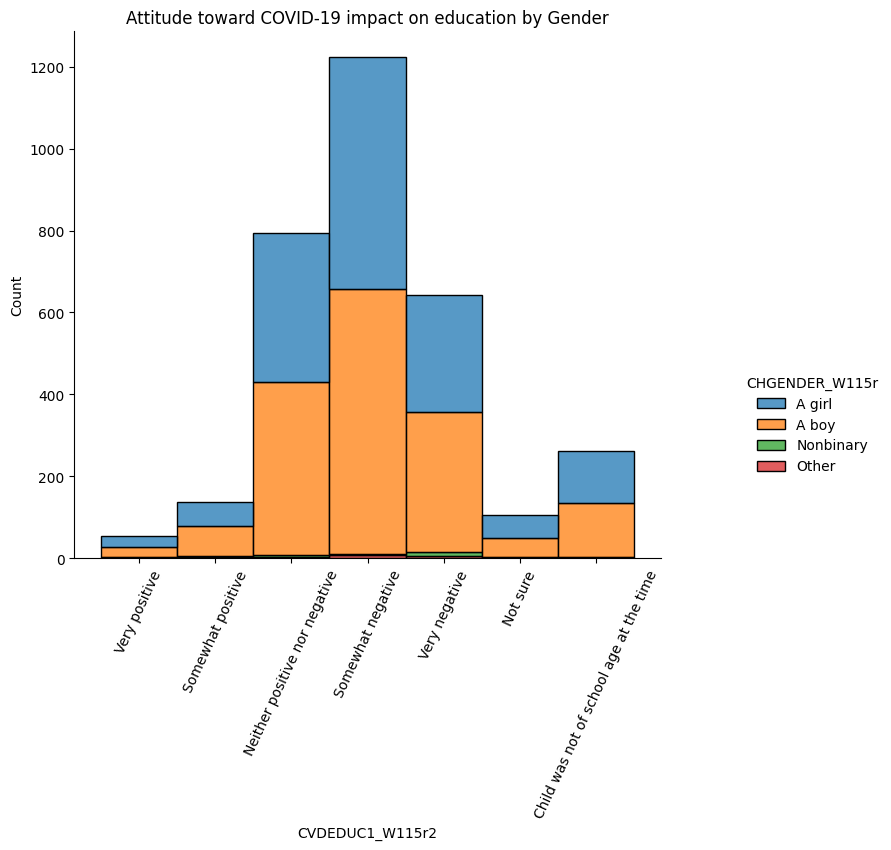

In [16]:
p = sb.displot(ATPW115_df, x='CVDEDUC1_W115r2', hue='CHGENDER_W115r', multiple="stack", height=6, aspect=1.25)
plt.title('Attitude toward COVID-19 impact on education by Gender')
plt.xticks(rotation=65)
plt.show()

In [34]:
ATPW115_df['F_BIRTHPLACE']

,F_BIRTHPLACE
0,4.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
3752,1.0
3753,1.0
3754,1.0
3755,1.0


In [65]:
# I'm going to read in some variables without converting them to categoricals in order to compute a linear model.

ATPW115_df = pd.read_spss('ATP W115.sav', usecols=['CVDEDUC1_W115',  'PARTNERSEXMOD_W115', 'F_GENDER', 'F_AGECAT', 'EMPLSIT_W115', 'F_MARITAL', 'F_RELIG', 'F_RACETHNMOD'], convert_categoricals=False)

In [66]:
# Create some binary vectors to identify demographic characteristics to model.
# Divide the questions into categories - easier to read
# You can do this manually:
ATPW115_df['partnersexman'] = 1
ATPW115_df.loc[ATPW115_df['PARTNERSEXMOD_W115'] == 1, ['partnersexman']] = 1

ATPW115_df['male'] = 1
ATPW115_df.loc[ATPW115_df['F_GENDER'] == 1, ['male']] = 1

ATPW115_df['age 18-29'] = 1
ATPW115_df.loc[ATPW115_df['F_AGECAT'] == 1, ['age 18-29']] = 1

ATPW115_df['fulltimepay'] = 1
ATPW115_df.loc[ATPW115_df['EMPLSIT_W115'] == 1, ['fulltimepay']] = 1

ATPW115_df['married'] = 1
ATPW115_df.loc[ATPW115_df['F_MARITAL'] == 1, ['married']] = 1

ATPW115_df['protestant'] = 1
ATPW115_df.loc[ATPW115_df['F_RELIG'] == 1, ['protestant']] = 1

ATPW115_df['white'] = 1
ATPW115_df.loc[ATPW115_df['F_RACETHNMOD'] == 1, ['white']] = 1


In [67]:
# Or, you can use the where() method in the NumPy library to create a binary using
# a logical test, as I did above to code missing values.
# WHERE method
ATPW115_df['partnersexman'] = np.where(ATPW115_df['PARTNERSEXMOD_W115'] == 1, 1, 0)

# This is more efficient code, but harder to read when you're learning Python

In [68]:
ATPW115_df.loc[ATPW115_df['CVDEDUC1_W115'] > 4, ['CVDEDUC1_W115']] = np.nan

# You can also write this as:
ATPW115_df['CVDEDUC1_W115r'] = np.where(ATPW115_df['CVDEDUC1_W115'] > 4, np.nan, ATPW115_df['CVDEDUC1_W115'])

In [69]:
# Linear model to predict belief in climate crisis
Y = ATPW115_df['CVDEDUC1_W115'] # A higher score indicates more negative effect to child's education during first year of COVID-19
X = ATPW115_df[['partnersexman', 'male', 'age 18-29', 'fulltimepay', 'married', 'protestant', 'white']]
X = sm.add_constant(X)
model0 = sm.OLS(Y, X, missing='drop').fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:          CVDEDUC1_W115   R-squared:                      -0.019
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    -40.86
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               1.00
Time:                        13:15:11   Log-Likelihood:                -2447.5
No. Observations:                2224   AIC:                             4899.
Df Residuals:                    2222   BIC:                             4910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
partnersexman    -0.0521      0.031     -1.667

In [70]:
# This is the same model, with the recoded DV, showing the same results.
# Linear model to predict belief in climate crisis
Y = ATPW115_df['CVDEDUC1_W115r'] # A higher score indicates more climate crisis skepticism
X = ATPW115_df[['partnersexman', 'male', 'age 18-29', 'fulltimepay', 'married', 'protestant', 'white']]
X = sm.add_constant(X)
model1 = sm.OLS(Y, X, missing='drop').fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         CVDEDUC1_W115r   R-squared:                      -0.019
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    -40.86
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               1.00
Time:                        13:15:37   Log-Likelihood:                -2447.5
No. Observations:                2224   AIC:                             4899.
Df Residuals:                    2222   BIC:                             4910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
partnersexman    -0.0521      0.031     -1.667

In [73]:
ATPW115_df['negative'] = np.where(ATPW115_df['CVDEDUC1_W115'] > 2, 1, 0)

In [74]:
# Logistic model to predict belief in climate crisis
Y = ATPW115_df['negative'] # binary measure of belief in climate crisis
X = ATPW115_df[['partnersexman', 'male', 'age 18-29', 'fulltimepay', 'married', 'protestant', 'white']]
X = sm.add_constant(X)
model2 = sm.Logit(Y, X, missing='drop').fit()
print(model2.summary())

         Current function value: 0.689040
         Iterations: 35


LinAlgError: Singular matrix

In [75]:
# import pandas as pd
# import statsmodels.api as sm
# import numpy as np

# Calculate correlation matrix
correlation_matrix = X.corr()

# Print the correlation matrix
print(correlation_matrix)

# Identify highly correlated variables (e.g., above 0.8 or -0.8)
highly_correlated = correlation_matrix[correlation_matrix > 0.8]
print(highly_correlated)

               partnersexman  male  age 18-29  fulltimepay  married  \
partnersexman            1.0   NaN        NaN          NaN      NaN   
male                     NaN   NaN        NaN          NaN      NaN   
age 18-29                NaN   NaN        NaN          NaN      NaN   
fulltimepay              NaN   NaN        NaN          NaN      NaN   
married                  NaN   NaN        NaN          NaN      NaN   
protestant               NaN   NaN        NaN          NaN      NaN   
white                    NaN   NaN        NaN          NaN      NaN   

               protestant  white  
partnersexman         NaN    NaN  
male                  NaN    NaN  
age 18-29             NaN    NaN  
fulltimepay           NaN    NaN  
married               NaN    NaN  
protestant            NaN    NaN  
white                 NaN    NaN  
               partnersexman  male  age 18-29  fulltimepay  married  \
partnersexman            1.0   NaN        NaN          NaN      NaN   
male     

In [76]:
model2_marginals = model2.get_margeff(at='median')
print(model2_marginals.summary())

NameError: name 'model2' is not defined

## Activity

1. Download a data file from the Pew Center. Copy the file to your Drive and read it into a data object.
2. Create a crosstabulation and a visualization to depict the relationship between a demographic variable and an attitudinal variable.
3. Create a linear model to predict the attitudinal variable.
4. Interpret the results.